In [1]:
import numpy as np
import pandas as pd
import fredpy as fp
import requests
import os
import matplotlib.pyplot as plt
import mock
from openpyxl.reader import excel
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

# Inflation Forecast and Inflation Data 
With the guidance of my professor's economic data repo @letsgoexploring, this program will download and manage data taken from the Federal Reserve Bank of Philadelphia, and actual inflation and interest rate data from FRED. The goal is to learn and practice techniques in data collection. 

In this notebook we learn about the differences about the actual and expected inflation and historical ex ante interest rates in the US. 

#### This is my key, apply for your own key on the FRED website

In [2]:
fp.api_key = fp.load_api_key(r"C:\Users\thoma\Desktop\Data\fred_api_key.txt")

# Downloading Forecast Data from SPF
https://www.philadelphiafed.org/surveys-and-data/real-time-data-research/inflation-forecasts

In [3]:
url = 'https://www.philadelphiafed.org/-/media/frbp/assets/surveys-and-data/survey-of-professional-forecasters/historical-data/inflation.xlsx?la=en&hash=F9C3E76769B4586C3E36E403DFA54BDC'

r = requests.get(url,verify=True)
with open(r"C:\Users\thoma\Desktop\Data\Econ\inflation.xlsx", "wb") as code:
    code.write(r.content)

Manage forecast data

In [4]:
# Loading data from Excel into python

try:
    inflation_forecasts = pd.read_excel(r"C:\Users\thoma\Desktop\Data\Econ\inflation.xlsx",sheet_name='INFLATION')
except:
    print('Formatting error in xlsx file persists: https://foss.heptapod.net/openpyxl/openpyxl/-/issues/1659')
    with mock.patch.object(excel.ExcelReader, 'read_properties', lambda self: None):
        inflation_forecasts = pd.read_excel(r"C:\Users\thoma\Desktop\Data\Econ\inflation.xlsx", dtype={'YEAR': str, 'QUARTER': str},sheet_name='INFLATION')

c:\Users\thoma\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [5]:
inflation_forecasts.head()

,YEAR,QUARTER,INFPGDP1YR,INFCPI1YR,INFCPI10YR
0,1970,1,NaN,NaN,NaN
1,1970,2,2.9851,NaN,NaN
2,1970,3,3.7037,NaN,NaN
3,1970,4,3.5414,NaN,NaN
4,1971,1,3.5303,NaN,NaN


In [6]:
# Making YEAR as the index
inflation_forecasts.index = pd.DatetimeIndex(inflation_forecasts['YEAR'].astype(int).astype(str)+'-Q'+inflation_forecasts['QUARTER'].astype(int).astype(str),freq = 'QS')

# Shift dates forward one year
inflation_forecasts.index = inflation_forecasts.index.shift(4)

# Drop unnecessary columns
inflation_forecasts = inflation_forecasts.drop(['YEAR','QUARTER','INFCPI10YR'],axis=1)

# Fill missing value for July 1974
inflation_forecasts = inflation_forecasts.interpolate(limit_area='inside')

# Rename remaining columns
inflation_forecasts.columns = ['DEFLATOR','CPI']

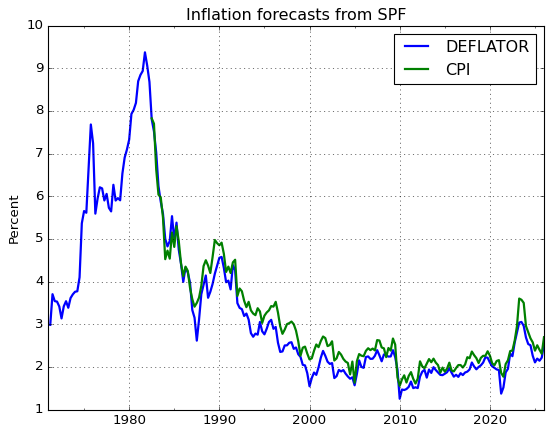

In [7]:
fig,ax = plt.subplots()
inflation_forecasts.plot(ax=ax,lw=2,grid=True)
ax.set_title('Inflation forecasts from SPF')
ax.set_ylabel('Percent');

### Download and Manage data from FRED
- GDP deflator (GDPDEF)
- CPI (CPIAUCSL)
- Yield on US Treasury Securities 1 Mo (GS1)

In [8]:
# Download GDP deflator data
deflator = fp.series('GDPDEF').data

# Construct inflation rate over previous 4 quarters
deflator = 100*(deflator/deflator.shift(4)-1)

In [9]:
# Download CPI data
cpi = fp.series('CPIAUCSL').data

# Construct inflation rate over previous 12 months
cpi = 100*(cpi/cpi.shift(12)-1)

# Take only CPI inflation values for the last month of quarter, but date as first month of quarter
cpi = cpi.resample('Q').ffill()
cpi = cpi.resample('QS').bfill()

C:\Users\thoma\AppData\Local\Temp\ipykernel_17412\1120932778.py:8: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  cpi = cpi.resample('Q').ffill()


In [10]:
# Download 1 year T-bill rate
nominal_rate = fp.series('GS1').data

# Convert to quarterly frequency 
nominal_rate = nominal_rate.asfreq('QS')

In [11]:
df = pd.concat([inflation_forecasts,deflator,cpi,nominal_rate],axis=1)
df = df[df['DEFLATOR'].notna()]

df.columns = [
    'deflator inflation - forecast',
    'cpi inflation - forecast',
    'deflator inflation - actual',
    'cpi inflation - actual',
    'nominal interest'
]

### Plots

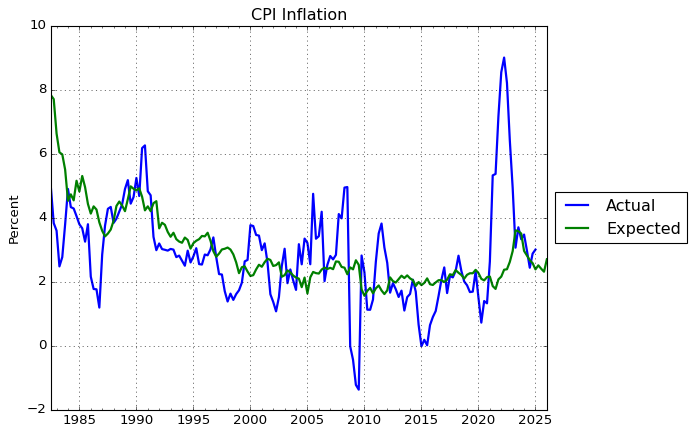

In [12]:
# Actual and forecasted CPI inflation
fig,ax = plt.subplots()
cpi = df[df['cpi inflation - forecast'].notna()][['cpi inflation - actual','cpi inflation - forecast']]
cpi.plot(legend=False,ax=ax,lw=2)

ax.legend(['Actual','Expected'],loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('CPI Inflation')
ax.set_ylabel('Percent')
ax.grid()

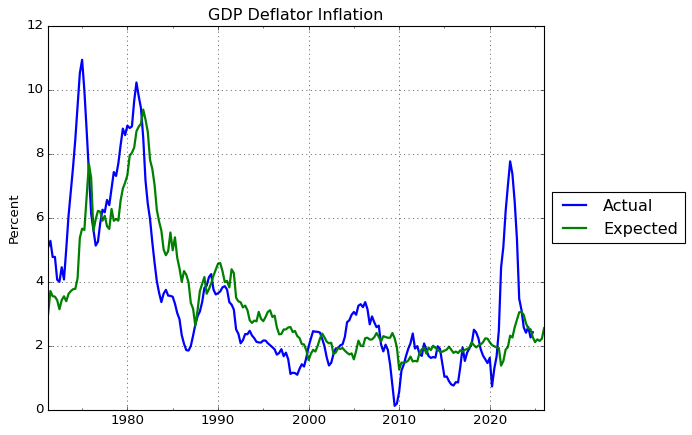

In [13]:
# Actual and forecasted GDP deflator inflation
fig,ax = plt.subplots()
deflator = df[df['deflator inflation - forecast'].notna()][['deflator inflation - actual','deflator inflation - forecast']]
deflator.plot(legend=False,ax=ax,lw=2)

ax.legend(['Actual','Expected'],loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('GDP Deflator Inflation')
ax.set_ylabel('Percent')
ax.grid()